# Feature Attribution

### This module gives information about which features affect the output of the module

## Import Libraries

In [37]:
import sys
import pickle
sys.path.append('../')
import pandas as pd
%matplotlib inline
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore')
from datetime import timedelta
from dateutil import parser
from sklearn.externals import joblib
import shap
from feature_attribution.feature_attribution import shapley
import matplotlib.pyplot as plt

#### Enable experiment tracking


In [38]:
import sys
sys.path.append('../../')
from Pynotebooks.core.experiment_tracker.abstract_tracker import local_tracker
tracker = local_tracker(base_folder='/tmp/', exp_file='exp_run.csv')

### Input Parameters

In [39]:
#Filename of the trained model (Random forest or XGBOOST)
model_file=tracker.get_input_param('model_file','finalized_model.sav')
#Filename of model object
filename_pkl=tracker.get_input_param('filename_pkl','forecast_mod_pkl.pkl')
#Filename of the dataset
input_file=tracker.get_input_param('input_file','/tmp/imputed_data.csv')
#Filename of the external dataset
#external_file=tracker.get_input_param('external_file','../data/elc_ext.csv')
#List of ID columns
id_cols=tracker.get_input_param('id_cols',['pg','dc'])
#Filename of the plot of feature importance which will be stored as a .png file
summary_plot_name =tracker.get_input_param('summary_plot_name', 'summary_plot')
#Filter data by columns and their respective values
filter_by = tracker.get_input_param('filter_by',{'pg':['LIGHT TRUCK TIRES'],'dc': ['8','70']})

#### Load the trained model

In [40]:
train_model = joblib.load(model_file)
train_model

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=3,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=1785, n_jobs=1,
           oob_score=False, random_state=100, verbose=0, warm_start=False)

#### Load the model object

In [41]:
with open(filename_pkl, 'rb') as f:
    model_obj = pickle.load(f)

### Read the input data

In [42]:
#read the input data
train = pd.read_csv(input_file, dtype={i:object for i in id_cols})
#read the external input data
#external = pd.read_csv(external_file, dtype={i:object for i in id_cols})
#merge the external data to the main input data file
#train = external.merge(train,how='left')
train

week_start                 pg   dc     quantity
0       05/01/13  LIGHT TRUCK TIRES    8  2206.000000
1       05/01/13  LIGHT TRUCK TIRES  645   717.000000
2       05/01/13  LIGHT TRUCK TIRES  897   672.000000
3       05/01/13  LIGHT TRUCK TIRES  605  3690.000000
4       05/01/13  LIGHT TRUCK TIRES   70  2639.000000
5       05/01/13  LIGHT TRUCK TIRES  124  1262.000000
6       05/01/13  LIGHT TRUCK TIRES  212  6906.000000
7       05/01/13  LIGHT TRUCK TIRES   85  1033.000000
8       05/01/13  LIGHT TRUCK TIRES  507  2126.000000
9       05/01/13  LIGHT TRUCK TIRES  180  2174.000000
10      05/01/13  LIGHT TRUCK TIRES  140  2386.000000
11      05/01/13  LIGHT TRUCK TIRES  309  1685.000000
12      05/01/13  LIGHT TRUCK TIRES  540   898.000000
13      05/01/13  LIGHT TRUCK TIRES  658  1747.157303
14      05/01/13  LIGHT TRUCK TIRES  252  1762.186441
15      05/01/13  LIGHT TRUCK TIRES  345   984.457627
16      05/01/13  LIGHT TRUCK TIRES  840  1281.000000
17      05/01/13  LIGHT TRUCK TIRES   18   814.000000
18      05/01/13  LIGHT TRUCK TIRES  255     4.000000
19      05/01/13  LIGHT TRUCK TIRES  604  1424.000000
20      05/01/13  LIGHT TRUCK TIRES  548   609.000000
21      05/01/13  LIGHT TRUCK TIRES  308  3231.000000
22      05/01/13  LIGHT TRUCK TIRES   75  1355.000000
23      05/01/13  LIGHT TRUCK TIRES  225  6648.000000
24      05/01/13  LIGHT TRUCK TIRES  318   806.000000
25      05/01/13  LIGHT TRUCK TIRES  675  1332.000000
26      05/01/13  LIGHT TRUCK TIRES   90  1861.000000
27      05/01/13  LIGHT TRUCK TIRES  123   849.000000
28      05/01/13  LIGHT TRUCK TIRES  280  2160.000000
29      05/01/13  LIGHT TRUCK TIRES   51  1914.000000
...          ...                ...  ...          ...
33640   16/12/17  LIGHT TRUCK TIRES  112  2658.000000
33641   16/12/17  LIGHT TRUCK TIRES   56  2133.000000
33642   16/12/17  LIGHT TRUCK TIRES  931  1169.753086
33643   16/12/17  LIGHT TRUCK TIRES   15  1148.000000
33644   16/12/17  LIGHT TRUCK TIRES  116  1407.000000
33645   16/12/17  LIGHT TRUCK TIRES  206  3633.000000
33646   16/12/17  LIGHT TRUCK TIRES   52  1470.000000
33647   16/12/17  LIGHT TRUCK TIRES  115  2021.000000
33648   16/12/17  LIGHT TRUCK TIRES  820  2521.000000
33649   16/12/17  LIGHT TRUCK TIRES  550  2737.000000
33650   16/12/17  LIGHT TRUCK TIRES  107  4600.000000
33651   16/12/17  LIGHT TRUCK TIRES   55  2410.000000
33652   16/12/17  LIGHT TRUCK TIRES  830  1815.000000
33653   16/12/17  LIGHT TRUCK TIRES   95  3150.000000
33654   16/12/17  LIGHT TRUCK TIRES  315   991.000000
33655   16/12/17  LIGHT TRUCK TIRES  682  1806.000000
33656   16/12/17  LIGHT TRUCK TIRES  603  2370.000000
33657   16/12/17  LIGHT TRUCK TIRES  585  2881.000000
33658   16/12/17  LIGHT TRUCK TIRES  303  2684.000000
33659   16/12/17  LIGHT TRUCK TIRES  121  2008.000000
33660   16/12/17  LIGHT TRUCK TIRES   53  1928.000000
33661   16/12/17  LIGHT TRUCK TIRES  307  3139.000000
33662   16/12/17  LIGHT TRUCK TIRES  618  1889.000000
33663   16/12/17  LIGHT TRUCK TIRES  660  2426.000000
33664   16/12/17  LIGHT TRUCK TIRES   62  2339.000000
33665   16/12/17  LIGHT TRUCK TIRES  900  2456.000000
33666   16/12/17  LIGHT TRUCK TIRES  522  1675.000000
33667   16/12/17  LIGHT TRUCK TIRES  260  3753.000000
33668   16/12/17  LIGHT TRUCK TIRES  502  5384.000000
33669   16/12/17  LIGHT TRUCK TIRES  141  1670.000000

[33670 rows x 4 columns]

### Generate the Shap data 

In [43]:
# Initialize the shapley module
data = shapley()
# Generate the shape data - filtered by the columns and values given as input parameters
shapley_data = data.generate_shap_data(model_obj.train,filter_by)
# Generate the shape data
shap_data = data.generate_features(shapley_data)

In [44]:
#intialise Shapley javascript
shap.initjs()

In [45]:
#generate the shapley values
explainer = shap.TreeExplainer(train_model)
shap_values = explainer.shap_values(shap_data)

In [46]:
#shapley value for each feature for each training set 
'''
shap_values is a numpy array of array whose length is equal to the length of the training set. 
Each array has the same number of elements are there are number of features in the training set and each value 
represents the shapley value calculated.

'''
shap_values_df = pd.DataFrame(shap_values,columns = [shap_data.columns])

In [47]:
# visualize the first prediction's explanation
# shows which features are contributing to push the model output from the base value to the output value
'''
shap.force_plot(explainer.expected_value, shap_values[ith prediction explaination,:(in the ith prediction, set of features explained)], new_train.iloc[ith prediction explaination,:])
'''
shap.force_plot(explainer.expected_value, shap_values[0,:], shap_data.iloc[0,:])

['pg', 'dc']


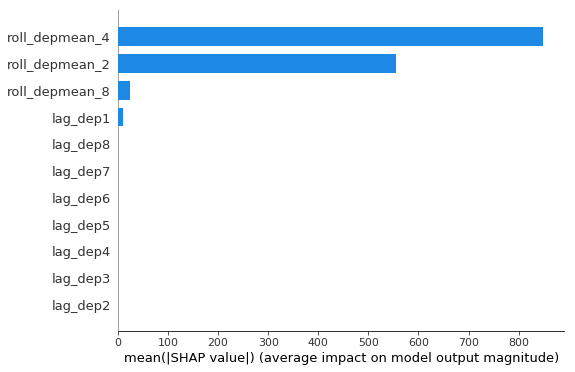

In [48]:
#Use this function if you want to filter only by the ID COLS
data.plot_by_id(model_obj.train,filter_by,shapley_data,explainer,shap,tracker,summary_plot_name)

### Plot the feature importance 

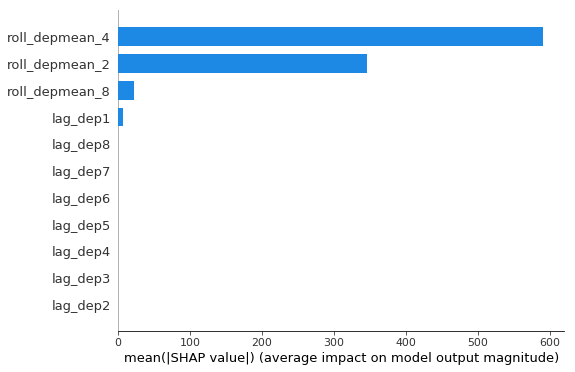

In [49]:
#Bar Plot of the feature importance

shap.summary_plot(shap_values, shap_data, plot_type="bar",show = False)
#Save the plot to the tracker.plot_folder with the name specified in the input parameters
plt.savefig(tracker.plot_folder+"/"+summary_plot_name+'.png')

## Output 

In [50]:
#Saving the shapley values for the features
tracker.set_output('shap_values_df',shap_values_df)

In [51]:
tracker.close()

{'exp_id': '123982',
 'start_time': '28/09/2018 10:56:59',
 'end_time': '28/09/2018 10:57:09',
 'runtime': '0:00:10.154821',
 'plots': '/tmp/123982/plot/',
 'labels': '{}',
 'input_params': '{"model_file": "finalized_model.sav", "filename_pkl": "forecast_mod_pkl.pkl", "input_file": "/tmp/imputed_data.csv", "external_file": "../data/elc_ext.csv", "id_cols": "[\'pg\', \'dc\']", "summary_plot_name": "summary_plot", "filter_by": "{\'pg\': [\'LIGHT TRUCK TIRES\'], \'dc\': [\'8\', \'70\']}"}',
 'output_metric': '{}',
 'output_data': '["/tmp/3944d1/data/shap_values_df.pkl", "/tmp/2ace1f/data/shap_values_df.pkl", "/tmp/123982/data/shap_values_df.pkl"]'}